# Create SOAR Observing Night Webpages

## 1. Initial Setup

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import glob
import math
import os
from shutil import copy2
from datetime import date

from matplotlib import path
from matplotlib.patches import Arrow
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.visualization import SqrtStretch
from astropy.visualization import LinearStretch
from astropy.visualization import LogStretch

from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import ZScaleInterval
from astropy.visualization import MinMaxInterval

from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel

from astropy.nddata import Cutout2D

import wcsaxes

%matplotlib inline

## 2. User Inputs 

In [2]:
mainDir='.'
nite='2019-04-02'
propID='2019A-0307'
observers='A. J. Cannon, C. Herschel, D. Hoffleit, M. Mitchell'
propPDF='des-gw_soar_noao_submitted.pdf'
priTargetCandidateList='./data/fakeKilonovaCandidates.csv'
priTargetName='GW'

In [3]:
niteSplit = nite.split('-')
#print niteSplit
YYYY=niteSplit[0]
MM=niteSplit[1]
DD=niteSplit[2]

## 3. Create the Webpages

In [4]:
def createFindingChartsFromDECamFITSImage(image_file, 
                                          target_radeg, target_decdeg, 
                                          target_id, target_name,
                                          outputDir):
    
    # Read in image...
    image_data = fits.getdata(image_file, ext=1)
    image_hdr = fits.getheader(image_file, ext=1)
    
    # We want zscale scaling...
    interval = ZScaleInterval()
    vlimits = interval.get_limits(image_data)
    # We want black stars on white background, so we switch the vmin/vmax limits...
    norm = ImageNormalize(vmin=vlimits[1], vmax=vlimits[0], stretch=LinearStretch())
    
    # Extract WCS from image header, and create a SkyCoord object for the target's coordinates...
    wcs = WCS(image_hdr)
    position = SkyCoord(target_radeg,target_decdeg, unit="deg", frame='icrs')
    
    # The arrow length for the North and East direction arrows...
    arrowLength = 60./0.263  # 1 arcmin arrow length (DECam pixel scale:  0.263arcsec/pixel)
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # CCD size finding chart:
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

    # Calculate the x,y position of the target in pixel coordinates...
    xy = skycoord_to_pixel(position, wcs)
    x = xy[0]
    y = xy[1]

    # Create figure...
    fig = plt.figure()
    ax=plt.subplot(1,1,1)
    plt.axis('off')
    
    # To get image to plot at the preferred orientiation (N at top, E at the right), 
    #  we transpose the image_data and set the origin of the plot as "upper"...
    im = ax.imshow(image_data.T, cmap='gray', origin='upper', norm=norm)
    
    # Circle the target (don't forget to transpose the x,y coordinates!)...
    ax.scatter(y,x, s=30, edgecolor='blue', facecolor='none')

    # Add title...
    title = """ObjID: %d  \n(Name: %s)""" % (target_id, target_name)
    plt.title(title, color='blue', fontsize=10) 

    # Add "compass rose"...
    a =  Arrow(200., 100., 0., arrowLength, edgecolor='black', facecolor='none')
    ax.add_patch(a)
    plt.text(200,100,'N',color='black')

    a =  Arrow(200., 100.+arrowLength, arrowLength, 0., edgecolor='black', facecolor='none')
    ax.add_patch(a)
    plt.text(200+arrowLength,100+arrowLength,'E',color='black')
    plt.text(50,25+0.5*arrowLength,'1.0\'',color='black',rotation=90)

    # Include color bar at the bottom of the plot...
    #fig.colorbar(im, orientation="horizontal")
    
    # Save figure
    outputFile = """objid_%d.%s.ccd_image.png""" % (target_id, target_name)
    outputFile = os.path.join(outputDir,outputFile)
    fig.savefig(outputFile, format='png')
    
    imageNameCCD = outputFile
    
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # 5arcmin x 5arcmin finding chart:
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

    # Create a 5arcmin x 5arcmin "Quantity" object...
    size = u.Quantity((5.0, 5.0), u.arcmin)

    # Create a 5arcmin x 5arcmin cutout from the full image data, 
    #  centered on the target ra, dec
    cutout = Cutout2D(image_data, position, size, mode='partial',wcs=wcs)

    # Calculate the x,y position of the target in pixel coordinates 
    #  within the 5arcmin x 5arcmin cutout...
    xy = skycoord_to_pixel(position, cutout.wcs)
    x = xy[0]
    y = xy[1]

    # Create figure...
    fig = plt.figure()
    ax=plt.subplot(1,1,1)
    plt.axis('off')

    # To get image to plot at the preferred orientiation (N at top, E at the right), 
    #  we transpose the cutout.data and set the origin of the plot as "upper"...
    ax.imshow(cutout.data.T, cmap='gray', origin='upper', norm=norm)

    # Circle the target (don't forget to transpose the x,y coordinates!)...
    ax.scatter(y,x, s=30, edgecolor='blue', facecolor='none')
    
    # Add title...
    text1 = """ObjID: %d""" % (target_id)
    text2 = """(Name:  %s)""" % (target_name)
    plt.text(0.5*size.value[1]*60./0.263,50,text1,color='blue',fontsize=10)
    plt.text(0.5*size.value[1]*60./0.263,50+0.05*size.value[0]*60./0.263,text2,color='blue',fontsize=10)

    # Add "compass rose"...
    a =  Arrow(50., 50., 0., arrowLength, edgecolor='black', facecolor='none')
    ax.add_patch(a)
    plt.text(50,50,'N',color='black')

    a =  Arrow(50., 50.+arrowLength, arrowLength, 0., edgecolor='black', facecolor='none')
    ax.add_patch(a)
    plt.text(50+arrowLength,50+arrowLength,'E',color='black')
    plt.text(-10,15+0.5*arrowLength,'1.0\'',color='black',rotation=90)

    # Include color bar at the side of the plot...
    #fig.colorbar(im)
    
    # Save figure
    outputFile = """objid_%d.%s.5x5arcmin.png""" % (target_id, target_name)
    outputFile = os.path.join(outputDir,outputFile)
    fig.savefig(outputFile, format='png')
    
    imageName5x5 = outputFile
    
    return (imageNameCCD,imageName5x5)


In [5]:
niteDir=os.path.join(mainDir,nite)
if not os.path.exists(niteDir):
    os.makedirs(niteDir)

logsDir=os.path.join(niteDir,'Logs')
if not os.path.exists(logsDir):
    os.makedirs(logsDir)
    
targetsDir=os.path.join(niteDir,'Targets')
if not os.path.exists(targetsDir):
    os.makedirs(targetsDir)
    
stdStarsDir=os.path.join(targetsDir,'StdStars')
if not os.path.exists(stdStarsDir):
    os.makedirs(stdStarsDir)

#stdStarsFile='StdStars.html'
#stdStarsFile=os.path.join(stdStarsDir,stdStarsFile)   
    
priTargetsDir=os.path.join(targetsDir,priTargetName)
if not os.path.exists(priTargetsDir):
    os.makedirs(priTargetsDir)

#priTargetsFile="""%s.html""" % (priTargetName)
#priTargetsFile=os.path.join(priTargetsDir,priTargetsFile)

priTargetsDataDir=os.path.join(priTargetsDir,'data')
if not os.path.exists(priTargetsDataDir):
    os.makedirs(priTargetsDataDir)

In [6]:
copyList = ['./data/AcqCam_Cheat_Sheet_Dec2015.pdf',    
            './data/AcqCam_User_Guide_Dec2015.pdf',
            './data/des-gw_soar_noao_submitted.pdf',
            './data/GOODMAN-log.pdf',
            './data/Goodman_Tutorial_2017.pdf',
            './data/OldSchoolTargetAcqForm.pdf', 
            './data/soar_quick_guide.pdf',
            './data/SOAR_TOO_Protocols.pdf',
            './data/goodman_hgar.dat', 
            './data/goodman_hgarne.dat',
            './data/contact_info.html', 
            './data/Observing_Plan.html',
            './data/Preferred_Instrument_Setup.html',
            './data/round13-poly.csv'
           ]

for fname in copyList:
    copy2(fname, niteDir)


fname = './data/StdStars.html'
copy2(fname, stdStarsDir)



In [7]:
#df_gw = pd.read_csv(priTargetCandidateList, comment='#')
#df_gw.FITSimage.tolist()


In [8]:
mainPage=os.path.join(niteDir,'index.html')

today = date.today()
todayString = today.strftime("%d %B %Y")
outputDateLine = """<EM>Last updated: %s </EM><BR>\n""" % todayString


fout = open(mainPage,'w')

fout.write("""<HTML>\n""")
fout.write("""<HEAD>\n""")
fout.write("""<TITLE>SOAR-4m GW Target of Opportunity (ToO) Nite:  """+nite+"""</TITLE>\n""")
fout.write("""</HEAD\n""")
fout.write("""\n""")
fout.write("""<BODY>\n""")
fout.write("""\n""")
fout.write("""<H1>SOAR-4m GW Target of Opportunity (ToO) Nite:  """+nite+"""</H1>\n""")
fout.write("""\n""")
fout.write("""<H2>Proposal:  """ + propID + """ (<A HREF=./des-gw_soar_noao_submitted.pdf>Full Text</A>) </H2> \n""")
fout.write("""\n""")
fout.write("""<b><i>SOAR ToO Policy Overview ( <A HREF=http://www.ctio.noao.edu/soar/content/targets-opportunity-overview>webpage</A> )""")
fout.write("""     and Specific ToO Protocols for SOAR 2018B ( <A HREF=./SOAR_TOO_Protocols.pdf>PDF</A> ) \n""")
fout.write("""</i></b>\n""")
fout.write("""\n""")
fout.write("""<H2> Observers</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""  <LI> """+ observers +"""\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""<P>\n""")
fout.write("""<H2> Communication</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""  <LI> <A HREF=./contact_info.html>Contact Information</A>\n""")
fout.write("""  <LI> <A HREF=https://darkenergysurvey.slack.com/messages/C1C5JCNLE/>DES GW Slack Channel (URL)</A>\n""")
fout.write("""  <LI> <A HREF=https://wiki.gw-astronomy.org/OpenLVEM/>OpenLVEM Wiki</A>\n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/cgi-bin/Calcium38.pl?Op=ShowIt&CalendarName=SOAR_Operations>SOAR TelOps Staffing Calendar</A>\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""<P>\n""")
fout.write("""<b><i></i></b>\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""<H2>Observing Strategy</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""<LI> <A HREF=./Preferred_Instrument_Setup.html> Preferred Instrument Setup</A>\n""")
fout.write("""<LI> <A HREF=./Observing_Plan.html>  Nightly Observing Plan</A>\n""")
fout.write("""<LI> <A HREF=http://www.briancasey.org/artifacts/astro/almanac.cgi?command=display&year="""+YYYY+"""&month="""+MM+"""&day="""+DD+"""&observatory=t&obslong=&obslat=&actual=&effective=&sitename=&zone=&zonename=&zoneabbrev=&daylight=>(CTIO) Sky Almanac for """+nite+"""</A>\n""")
fout.write("""<LI> <A HREF=./Targets/Targets.html>Targets</A>:\n""")
fout.write("""	<UL>\n""")
fout.write("""	  <LI> <A HREF=./Targets/"""+priTargetName+"""/"""+priTargetName+""".html>"""+priTargetName+"""</A>\n""")
fout.write("""	  <LI> <A HREF=./Targets/StdStars/StdStars.html> Standard Stars</A>\n""")
fout.write("""	</UL>\n""")
fout.write("""<LI> <A HREF=./Logs/Logs.html>Nightly Observing Logs</A>\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""<H2>Guides</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""<LI> <A HREF=http://www.ctio.noao.edu/soar/content/observing-soar>Observing with SOAR</A>\n""")
fout.write("""<LI> <A HREF=http://www.ctio.noao.edu/soar/content/soar-astronomersobservers>SOAR Instrumentation</A>\n""")
fout.write("""<LI> <A HREF=http://www.ctio.noao.edu/soar/content/goodman-high-throughput-spectrograph>Goodman High Throughput Spectrograph</A> \n""")
fout.write("""  <UL>\n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/soar/sites/default/files/GOODMAN/Images/New_Goodman_Cheat_Sheet.pdf>Goodman Spectrograph Cheat Sheet</A>  \n""")
fout.write("""  <LI> Step-by-Step User's Guide (2017) \n""")
fout.write("""    (<A HREF=http://www.ctio.noao.edu/soar/sites/default/files/GOODMAN/Goodman_Tutorial_2017.pdf>web version</A>, \n""")
fout.write("""     <A HREF=./Goodman_Tutorial_2017.pdf>local version</A>) \n""")
fout.write("""  <LI> <A HREF=./soar_quick_guide.pdf>Melissa Butner's Quick Guide</A>\n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/soar/content/goodman-long-slits> Available long slits</A>\n""")
fout.write("""  </UL>\n""")
fout.write("""<LI> Goodman Acquistion Camera (GACAM) Users's Manual\n""")
fout.write("""     (<A HREF=http://www.ctio.noao.edu/soar/sites/default/files/GOODMAN/AcqCam_User_Guide_Dec2015.pdf>web version</A>, \n""")
fout.write("""     <A HREF=./AcqCam_User_Guide_Dec2015.pdf>local version</A>)\n""")
fout.write("""   <UL>\n""")
fout.write("""     <LI> Goodman Acquistion Camera (GACAM) Cheat Sheet\n""")
fout.write("""          (<A HREF=http://www.ctio.noao.edu/soar/sites/default/files/GOODMAN/AcqCam_Cheat_Sheet_Dec2015.pdf>web version</A>, \n""")
fout.write("""           <A HREF=./AcqCam_Cheat_Sheet_Dec2015.pdf>local version</A>) \n""")
fout.write("""   </UL>\n""")
fout.write("""<LI> <A HREF=https://docs.google.com/document/d/1GT4qqnBWrycDa3hsiRCXYAEHA0RdDQjJ-oFvDxPOJec/edit#heading=h.cfhdub4lvrzk>Remote Observing from FNAL (DECam-specific)</A> \n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""<H2>Sky Conditions</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/soar/content/weather-sky-monitoring-tools>Pachon and Tololo Weather, Sky Conditions, and Monitoring Tools</A>\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""<H2>Utilities</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""<LI> <A HREF=http://skyview.gsfc.nasa.gov/>SkyView</A>\n""")
fout.write("""<LI> <A HREF=http://aps.umn.edu/catalog/finder_chart/> MAPS finder chart engine</A>\n""")
fout.write("""<LI> <A HREF=http://deslabs.ncsa.illinois.edu/>DES Labs</A>\n""")
fout.write("""	<UL> \n""")
fout.write("""	  <LI> <A HREF=http://descut.cosmology.illinois.edu/>Cutout Server</A>\n""")
fout.write("""	  <LI> <A HREF=http://descut.cosmology.illinois.edu/footprint>Footprint Server</A>\n""")
fout.write("""	</UL>\n""")
fout.write("""\n""")
fout.write("""<LI> <A HREF=http://www.briancasey.org/artifacts/astro/> Brian Casey's Astronomy Tools:</A>\n""")
fout.write("""	<UL> \n""")
fout.write("""	  <LI> <A HREF=http://www.briancasey.org/artifacts/astro/airmass.cgi> Hourly Airmass Tables</A>\n""")
fout.write("""	  <LI> <A HREF=http://www.briancasey.org/artifacts/astro/skycalendar.cgi> Monthly Sky Calendar</A>\n""")
fout.write("""	  <LI> <A HREF=http://www.briancasey.org/artifacts/astro/observability.cgi> Object Seasonal Observability</A>\n""")
fout.write("""	</UL>\n""")
fout.write("""<LI> <A HREF=http://www.fourmilab.ch/cgi-bin/Yoursky?z=1&lat=30.165&ns=South&lon=70.815&ew=West> Sky Chart for CTIO</A>\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""<H2>Data Processing Material</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""\n""")
fout.write("""  <LI> <A HREF=https://github.com/DouglasLeeTucker/SOAR_Goodman_QuickReduce>SOAR Goodman Quick Reduce</A> <b><i>(Prototype for quick on-the-fly reductions.)</i></b>\n""")
fout.write("""  \n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/soar/content/goodman-data-reduction-pipeline>The Goodman Data Reduction Pipeline</A> <b><i>(NEW -- but not currently useable for our 400_WD configuration.)</i></b>\n""")
fout.write("""  \n""")
fout.write("""  <LI> Comparison Arc Spectra\n""")
fout.write("""    <UL>\n""")
fout.write("""      <LI> HgAr: <A HREF=http://www.ctio.noao.edu/soar/sites/default/files/Instrument_Plots/400m1_HgAr_3000-7000.pdf>plot (3000A-7000A)</A>, <A HREF=./goodman_hgar.dat>linelists</A>\n""")
fout.write("""      <LI> HgAr+Ne: <A HREF=./goodman_wd400_hgarne.png>plot (3750A-7150A)</A>, <A HREF=http://www.ctio.noao.edu/soar/sites/default/files/GOODMAN/HgArNe_400M2_GG455_full.pdf>plot (5000A-9000A)</A>, <A HREF=./goodman_hgarne.dat>linelists</A>\n""")
fout.write("""    </UL>\n""")
fout.write("""    \n""")
fout.write("""  \n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""<H2>Forms</H2>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/soar/content/instrument-setup-forms-and-observing-reports>\n""")
fout.write("""	  General SOAR Instrument Setup Forms and Observing Reports</A>\n""")
fout.write("""     <UL>\n""")
fout.write("""     <LI> <A HREF=http://www.ctio.noao.edu/SOAR/Forms/INST/setup.php>Instrument Setup Form</A>\n""")
fout.write("""     <LI> <A HREF=http://www.ctio.noao.edu/SOAR/Forms/EON/Form.php?telescope=SOAR> SOAR End-of-night form</A>\n""")
fout.write("""     <LI> <A HREF=http://www.ctio.noao.edu/new/Tools/Forms/EOR/Form.php?telescope=SOAR> SOAR End-of-run form</A>\n""")
fout.write("""     </UL>\n""")
fout.write("""<LI> Goodman Paper Log\n""")
fout.write("""     (<A HREF=http://www.ctio.noao.edu/soar/sites/default/files/documents/GOODMAN-log.pdf>web version</A>, \n""")
fout.write("""      <A HREF=./GOODMAN-log.pdf>local version</A>)\n""")
fout.write("""<LI> <A HREF=./OldSchoolTargetAcqForm.pdf>Faint-Object Target Acquisition Checklist</A> (print out a copy for each target fainter than i=19)\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""<HR>\n""")
fout.write(outputDateLine)
#fout.write("""<EM>Last updated:  12 December 2018 </EM><BR>\n""")
fout.write("""\n""")
fout.write("""</BODY>\n""")
fout.write("""</HTML>\n""")
fout.write("""\n""")

fout.close()

In [9]:
targetsPage=os.path.join(targetsDir,'Targets.html')

today = date.today()
todayString = today.strftime("%d %B %Y")
outputDateLine = """<EM>Last updated: %s </EM><BR>\n""" % todayString

fout = open(targetsPage,'w')

fout.write("""<HTML>\n""")
fout.write("""<HEAD>\n""")
fout.write("""<TITLE>SOAR Observing Run:  Targets</TITLE>\n""")
fout.write("""</HEAD>\n""")
fout.write("""\n""")
fout.write("""<BODY>\n""")
fout.write("""\n""")
fout.write("""<H2> Targets</H2>\n""")
fout.write("""\n""")
fout.write("""<HR>  \n""")
fout.write("""\n""")
fout.write("""<H3>"""+priTargetName+""" Targets</H3>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""  <LI> <A HREF=./"""+priTargetName+"""/"""+priTargetName+""".html>Main Page</A>\n""")
fout.write("""  <LI> <A HREF=./"""+priTargetName+"""/"""+priTargetName+""".obs_strategy.html>Finding Charts, Estimated Exposure Times, Airmass Tables, etc.)</A>\n""")
fout.write("""  <LI> <A HREF=./"""+priTargetName+"""/"""+priTargetName+""".goodman_targetlist.txt>SOAR TCS-formatted Target List</A>\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""<HR>\n""")
fout.write("""\n""")
fout.write("""<H3>Standard Stars</H3>\n""")
fout.write("""\n""")
fout.write("""<UL>\n""")
fout.write("""  <LI> <A HREF=./StdStars/StdStars.html>Main Page</A>\n""")
fout.write("""  <LI> <A HREF=http://www.ctio.noao.edu/soar/content/hamuy-spectrophotometric-standards>Hamuy Spectrophotometric Standards</A>\n""")
fout.write("""</UL>\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""<HR>\n""")
fout.write("""\n""")
fout.write("""<A HREF=../index.html>Return to Main Page</A>\n""")
fout.write("""\n""")
fout.write("""<HR>\n""")
fout.write(outputDateLine)
#fout.write("""<EM>Last updated:  12 December 2018</EM>\n""")
fout.write("""<BR>\n""")
fout.write("""\n""")
fout.write("""</BODY>\n""")
fout.write("""</HTML>\n""")
fout.write("""\n""")

fout.close()

Finis


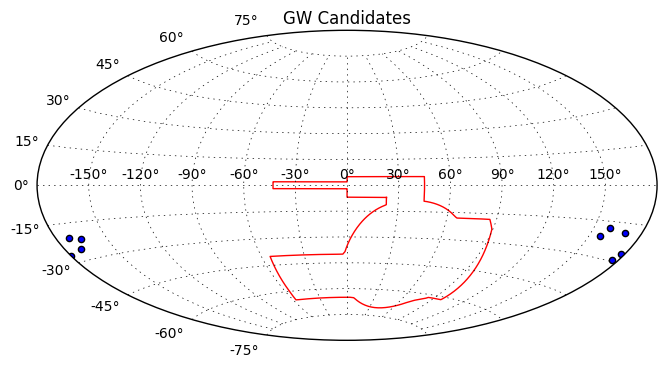

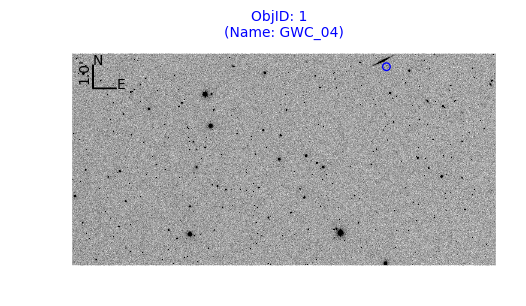

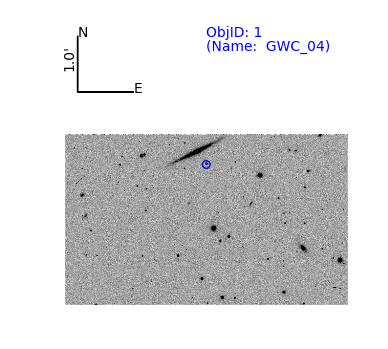

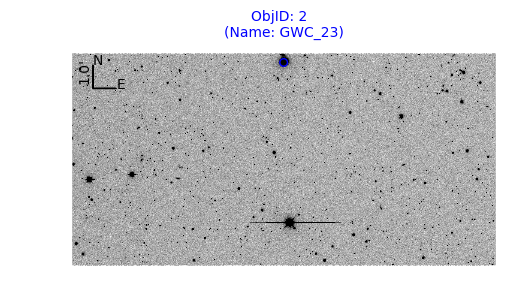

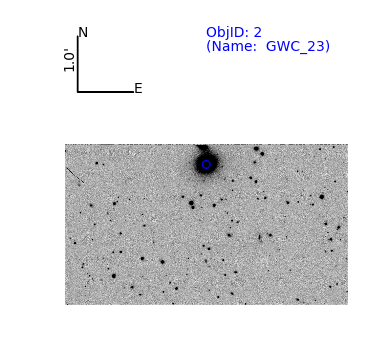

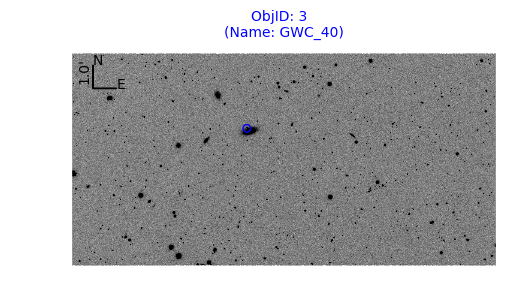

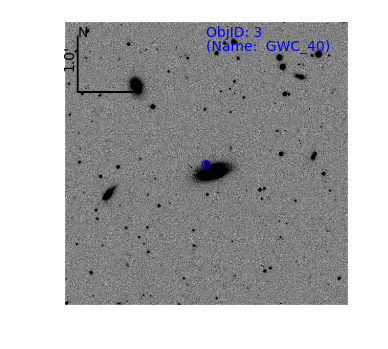

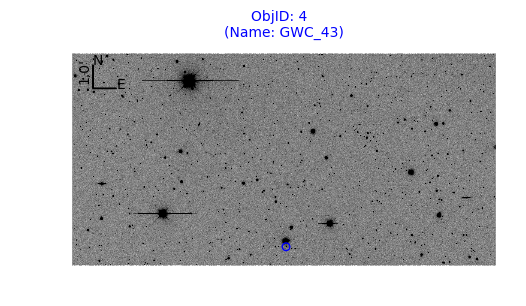

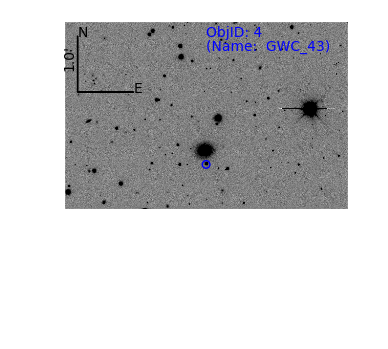

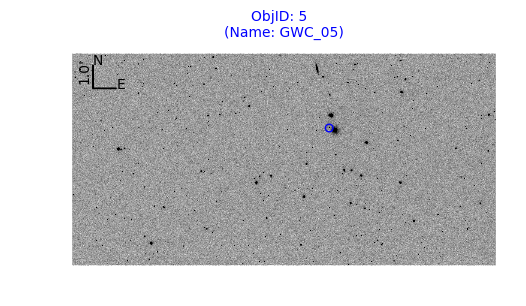

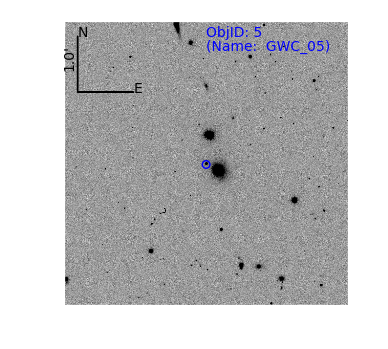

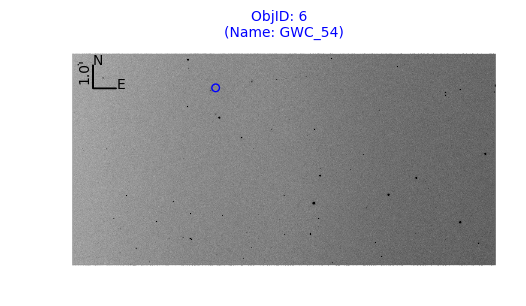

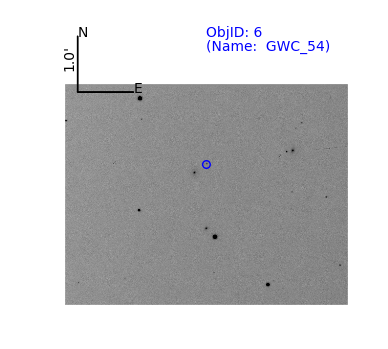

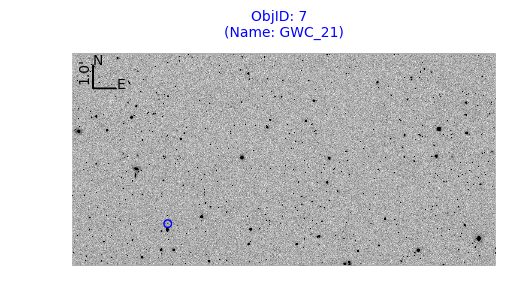

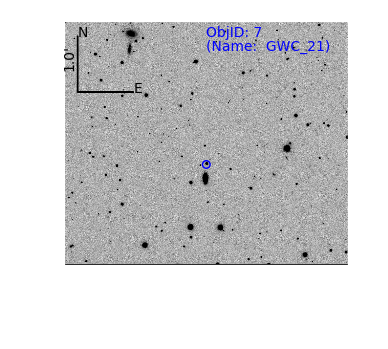

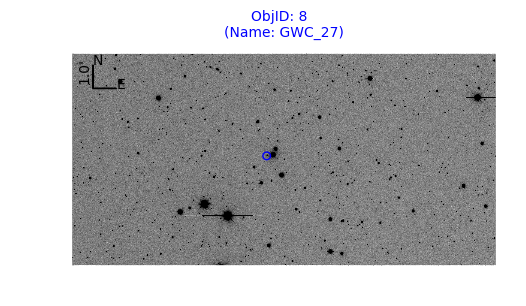

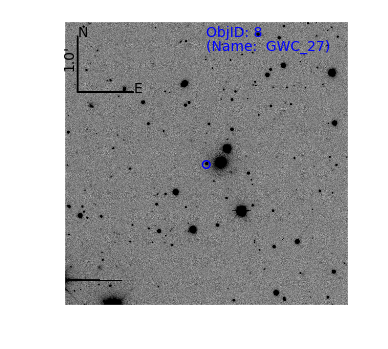

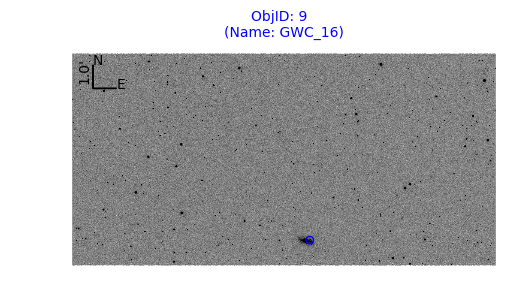

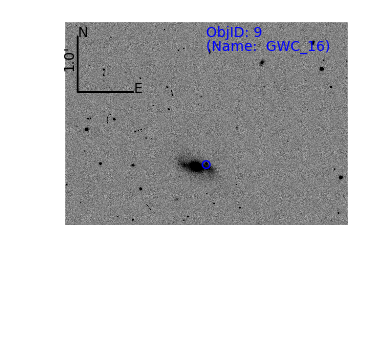

In [19]:
# Take from ~/Desktop/ObservingRuns/Chile2018b/SOAR4m/SOAR-Feb2019/Targets/GW/python/createGWTargetListHTML.py

# DES footprint coordinates...
#  Read in round13-poly.csv file...
polygonDataDF = pd.read_csv('./data/round13-poly.csv')
ra_des = coord.Angle(polygonDataDF['radeg'], unit=u.degree)
dec_des = coord.Angle(polygonDataDF['decdeg'], unit=u.degree)

# Read in GW candidate list file...
df_gw = pd.read_csv(priTargetCandidateList, comment='#')

# Sort by priority and magnitude...
df_gw.sort_values(by=['priority','mag'], ascending=True, inplace=True)

# And reset index...
df_gw.reset_index(inplace=True,drop=True)

# Add ID column
df_gw['ID'] = 1 + df_gw.index

# Print out sorted candidate list...
df_gw

# Create raHMS, decDMS from radeg, decdeg (for kilonova, not galaxy)
# See http://www.astropy.org/astropy-tutorials/plot-catalog.html
df_gw['raHMS'] = coord.Angle(df_gw['radeg'], unit=u.degree).to_string(unit=u.hour, sep=':', precision=2)
df_gw['decDMS'] = coord.Angle(df_gw['decdeg'], unit=u.degree).to_string(unit=u.degree, sep=':', precision=1)

# Move radeg to radeg_nowrap and create a new, wrapped-at-180deg radeg column...
df_gw.loc[:,'radeg_nowrap'] = df_gw.loc[:,'radeg']
mask = (df_gw['radeg'] >= 180.0)
df_gw.loc[mask,'radeg'] = df_gw.loc[mask,'radeg'] - 360.

# Create a column in "df_gw" containing the magnitude rounded to hundredths...
df_gw['mag_rnd'] = df_gw['mag'].round(2)

## For generic SOAR targets for which we want S/N~30:
##  total exptime = 10.**(0.400*i-4.133)
## (See Magellan Jan 2019 Run python script).
# For the GW program, we want a single exposure to be roughly:
#   900sec for i<=18.5      (this is probably a bit too much)
#  1200sec for 18.5<i=<19.5 (this is probably a bit too much)
#  1800sec for 19.5<i<20.5  (this is probably not enough, especially on the fainter end)
# This should be improved, especially for fainter objects not much above sky background.
# It may be hard to use SOAR for objects fainter than i=20.0, although we got not unreasonable
#  S/N in January 2019 for a practice target at G=19.9 in 1800 seconds. 
df_gw.loc[:,'exptime_ind'] = np.power(10.,0.400*df_gw.loc[:,'mag_rnd']-4.133)/3.
# For particularly bright objects, no need to go below 30 sec for an individual exposure.
mask = (df_gw['mag_rnd'] < 15.2)
df_gw.loc[mask,'exptime_ind'] = 30.
# Total exposure time (if identified as the kilonova):
df_gw.loc[:,'exptime'] = 3.*df_gw.loc[:,'exptime_ind']

## Merge df_gw with comments file...
#gw_merged = pd.merge(df_gw,df_gwnotes,how='left',on='ID', suffixes=('', '_2'))

# Clean up 'nan' comments...
df_gw.comments.fillna('',inplace=True)


# Plot sky distribution of each set of candidates...
# GW coordinates...
ra_gw = coord.Angle(df_gw.radeg, unit=u.degree)
dec_gw = coord.Angle(df_gw.decdeg, unit=u.degree)
fig = plt.figure(figsize=(8,6))
#ax = fig.add_subplot(111, projection="mollweide")
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(ra_gw.radian, dec_gw.radian, c='b') # GW candidates...
plt.plot(ra_des.radian, dec_des.radian, 'r-')  # DES footprint outline...
plt.grid(True)
plt.title('GW Candidates')
outputFile = os.path.join(priTargetsDir,'GWtargets.radec.png')
plt.savefig(outputFile,format='png')


# Create ds9 region file containing regions for all the candidates...
regFile = 'GWtargets.'+nite+'.reg'
freg_out = open(os.path.join(priTargetsDataDir,regFile),'w')
# Write header infor into ds9 region file...
freg_out.write("""# Region file format: DS9 version 4.1\n""")
freg_out.write("""global color=green dashlist=8 3 width=1 font=\"helvetica 10 normal roman\" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n""")
freg_out.write("""fk5\n""")


# Open priTargetsPage (fout)...
priTargetsPage=os.path.join(priTargetsDir, priTargetName+'.html')
fout = open(priTargetsPage,'w')

#Write HTML header/first part of main body into priTargetsPage (fout)
fout.write("""<HTML>\n""")
fout.write("""<HEAD>\n""")
fout.write("""<TITLE>SOAR Observing Run:  """+priTargetName+""" Targets</TITLE>\n""")
fout.write("""</HEAD>\n""")
fout.write("""\n""")
fout.write("""<BODY>\n""")
fout.write("""\n""")
fout.write("""<H2>"""+priTargetName+""" Targets</H2>\n""")
fout.write("""\n""")
fout.write("""<H3> Target Lists:</H3>\n""")
fout.write("""<UL>\n""")
fout.write("""<LI> <A HREF=./"""+priTargetName+"""targets.obs_strategy.html> Formatted for Observing Strategy</A> (includes Estimated Exposure Times, Finding Charts, Airmass Tables, etc.)\n""")
fout.write("""<LI> <A HREF=./"""+priTargetName+"""targets.goodman_targetlist.txt> Formatted for the SOAR-4m TCS</A>\n""")
fout.write("""</UL>\n""")
fout.write("""<H3> <H3>Mosaic of Target Images (from DECam): </H3>\n""")
fout.write("""\n""")
#fout.write("""<table border cellspacing=0 cellpadding=0>\n""")
#fout.write("""<table border\n""")
fout.write("""<table border cellspacing=0 cellpadding=20>\n""")

# Open GWtargets.obs_strategy.html (fout2)...
outputFile2 = os.path.join(priTargetsDir,'GWtargets.obs_strategy.html')
fout2 = open(outputFile2,'w')

#Write HTML Header into GWtargets.obs_strategy.html
fout2.write('<HTML>\n')
fout2.write('<HEAD>\n')
fout2.write('<TITLE>GW Candidates Target List</TITLE>\n')
fout2.write('</HEAD>\n')
fout2.write('\n')
fout2.write('<BODY>\n')
fout2.write('\n')
fout2.write('<H2>GW Candidates Target List</H2>\n')
fout2.write('\n')
fout2.write('<P>\n')
fout2.write('<i>Note 1:  SkyView finding charts are 10arcmin on a side (in imaging mode, the Goodmann Spectrograph has a FOV of 7.2arcmin)</i>\n')
fout2.write('<P>\n')
fout2.write('<i>Note 2:  Airmass table is for the night of '+nite+'.</i>\n')
fout2.write('<P>\n')
fout2.write('<i>Note 3:  xephem data file can be found <A HREF=./GWtargets.xephem.edb>here</A>.  (Download and copy into your ~/.xephem directory.)</i>\n')
fout2.write('<P>\n')
#fout2.write('<i>Note 4:  Finding chart FITS files, a global ds9 region file for these FITS files, and corresponding JPG images can be found in des30:/opt/des-cal/calib/DESCalibObsRuns/SOAR-Jan2019/Targets/GW/data/FITS on the FNAL DES cluster.  (Links to the FITS files and the global ds9 region file can be found in the Comments column of the target list below.)</i>\n')
#fout2.write('<P>\n')
fout2.write('\n')
fout2.write('\n')
fout2.write('<PRE>\n')

outputFile3 = os.path.join(priTargetsDir,'GWtargets.goodman_targetlist.txt')
fout3 = open(outputFile3,'w')
fout3.write('#OBJECT_ID RAHMS DECDMS EPOCH\n')

outputFile3a = os.path.join(priTargetsDir,'GWtargets.des_targetviewer_list.csv')
fout3a = open(outputFile3a,'w')

outputFile4 = os.path.join(priTargetsDir,'GWtargets.xephem.edb')
fout4 = open(outputFile4,'w')


# Iterate through GW "df_gw", outputting the target list (fout2,fout3,fout3a,fout4) 
#  and image mosaic (fout)...
#fout2.write('\n')
fout2.write('<font color="blue"><b>========================================</b></font>\n')
fout2.write('<font color="blue"><b>GW Candidates Target List</b></font>\n')
fout2.write('<font color="blue"><b>========================================</b></font>\n')
#fout2.write('\n')
fout2.write('\n')
fout2.write('ID#    Name                         RA(2000)       Dec(2000)         mag     exptime(sec)                          Finding Chart Files                                      Airmass Table    Comments\n')
fout2.write('-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n')
fout2.write('\n')

irow = 0
nrow = df_gw.FITSimage.size

for index, row in df_gw.iterrows():

    irow = irow + 1
    
    idnum = row['ID']

    name_gw = row['name']
    
    band_gw = row['band']

    fitsFile_input_gw = row['FITSimage']
    fitsFile_gw = os.path.basename(fitsFile_input_gw)

    ra_gw_hms = str(row['raHMS'])
    dec_gw_dms = str(row['decDMS'])

    ra_gw_hms_list = ra_gw_hms.split(':')
    ra_gw_hh = str(ra_gw_hms_list[0])
    ra_gw_mm = str(ra_gw_hms_list[1])
    ra_gw_ss = str(ra_gw_hms_list[2])

    dec_gw_dms_list = dec_gw_dms.split(':')
    dec_gw_dd = str(dec_gw_dms_list[0])
    dec_gw_mm = str(dec_gw_dms_list[1])
    dec_gw_ss = str(dec_gw_dms_list[2])

    ra_gw = row['radeg']
    ra_nowrap_gw = row['radeg_nowrap']
    dec_gw = row['decdeg']

    mag_gw = row['mag']
    mag_gw_round = row['mag_rnd']
    
    totExpTime = row['exptime']
    expTime = row['exptime_ind']

    comments = row['comments']

    #comments = """<A HREF=%s>local FITS file</A>, <A HREF=%s>ds9 region file</A>   %s""" % (fitsFile, regFile, comments)

    # Create png finding chart images...
    imageNameCCD,imageName5x5 = \
        createFindingChartsFromDECamFITSImage(fitsFile_input_gw, 
                                              ra_nowrap_gw, dec_gw, 
                                              idnum, name_gw, 
                                              priTargetsDataDir)
        
    # Copy original FITS image to priTargetsDataDir
    copy2(fitsFile_input_gw,priTargetsDataDir)
    fitsFile_gw = os.path.basename(fitsFile_input_gw)
    
    # Add entry to combined ds9 region file...
    freg_out.write("""circle(%f,%f,10.0") # color=blue text={%s}\n""" % (ra_nowrap_gw, dec_gw, name_gw))

    # Extract the filename for imageNameCCD and imageName5x5 from their pathnames...
    imageNameCCD = os.path.basename(imageNameCCD)
    imageName5x5 = os.path.basename(imageName5x5)
    
    outputLine2 = '%5d  %-26s   %-13s %-14s    %5.2f   %4d (=3x%4d)      DECam cutout (<A HREF=./data/%s>png</A>), DECam CCD image (<A HREF=./data/%s>png</A>,<A HREF=./data/%s>FITS</A>), <A HREF=./data/%s>ds9 reg file</A>, <A HREF=http://skyview.gsfc.nasa.gov/cgi-bin/runquery.pl?Survey=DSS2+Red&GRID=J2000&gridlabels=1&position=%2s+%2s+%4s,%3s+%2s+%2s&Size=0.166667&Pixels=600&Return>SkyView</A>       <A HREF=http://www.briancasey.org/artifacts/astro/airmass.cgi?observatory=t&obslong=&obslat=&actual=&effective=&site=&zone=&zonename=&zoneabbrev=&daylight=1&year=%s&month=%s&day=%s&starname=%s&rightasc=%2s+%2s+%4s&declin=%3s+%2s+%2s&epoch=2000&altitude=-18&command=display>Airmass Table</A>    %s' % \
                  (idnum, name_gw, ra_gw_hms, dec_gw_dms, \
                   mag_gw, int(totExpTime), int(expTime), \
                   imageName5x5, imageNameCCD, fitsFile_gw, regFile, \
                   ra_gw_hh, ra_gw_mm, ra_gw_ss, \
                   dec_gw_dd, dec_gw_mm, dec_gw_ss, \
                   YYYY, MM, DD, name_gw, ra_gw_hh, ra_gw_mm, ra_gw_ss, \
                   dec_gw_dd, dec_gw_mm, dec_gw_ss, \
                   comments)

    outputLine2 = outputLine2+'\n\n'
    fout2.write(outputLine2)
    

    outputLine3 = '[%d]OBJECT_ID %s %s 2000.0' % \
                  (idnum, ra_gw_hms, dec_gw_dms)
    outputLine3 = outputLine3+'\n'
    fout3.write(outputLine3)

    outputLine3a = '%.6f,%.5f' % \
                  (ra_nowrap_gw, dec_gw)
    outputLine3a = outputLine3a+'\n'
    fout3a.write(outputLine3a)

    symbSize = mag_gw-18.
    outputLine4 = '%s,f|S|O,%s,%s,%f.3,2000.00' % \
                  (name_gw,ra_gw_hms, dec_gw_dms, symbSize)
    outputLine4 = outputLine4+'\n'
    fout4.write(outputLine4)


    # If this is an odd-numbered row, start a new table row for the mosaic of target images...
    if (irow%2) == 1:
        fout.write("""<tr>\n""")
    
    # Produced entry for this target in the mosaic of target images...
    fout.write("""<td> <img src=data/%s>\n""" % (imageName5x5))
    fout.write("""<P>\n""")
    fout.write("""<center>\n""")
    fout.write("""<table border>\n""")
    fout.write("""  <tr>\n""")
    fout.write("""  <th>RA</th>\n""")
    fout.write("""  <th>DEC</th>\n""")
    fout.write("""  <th>mag</th>\n""")
    fout.write("""  <th>ExpTime (sec)</th>\n""")
    fout.write("""  <th>Airmass Table</th>\n""")
    fout.write("""  </tr>\n""")
    fout.write("""  <tr>\n""")
    fout.write("""  <td>%s</td>\n""" % (ra_gw_hms))
    fout.write("""  <td>%s</td>\n""" % (dec_gw_dms))
    fout.write("""  <td>%5.2f (%s-band)</td>\n""" % (mag_gw, band_gw))
    fout.write("""  <td>%d (=3x %d)</td>\n""" % (int(totExpTime), int(expTime) ))
    fout.write("""  <td><a href=http://www.briancasey.org/artifacts/astro/airmass.cgi?observatory=t&obslong=&obslat=&actual=&effective=&site=&zone=&zonename=&zoneabbrev=&daylight=1&year=%s&month=%s&day=%s&starname=%s&rightasc=%2s+%2s+%4s&declin=%3s+%2s+%2s&epoch=2000&altitude=-18&command=display>%s-%s-%s</a>\n""" % (YYYY, MM, DD, name_gw, ra_gw_hh, ra_gw_mm, ra_gw_ss, dec_gw_dd, dec_gw_mm, dec_gw_ss, YYYY, MM, DD))
    fout.write("""  </tr>\n""")
    fout.write("""</table>\n""")
    fout.write("""</center>\n""")
    fout.write("""<P>\n""")
    fout.write("""<center>\n""")
    fout.write("""<table border>\n""")
    fout.write("""  <tr>\n""")
    fout.write("""  <th>5'x5' DECam cutout</th>\n""")
    fout.write("""  <th>Full DECam CCD image</th>\n""")
    fout.write("""  <th>ds9 region file</th>\n""")
    fout.write("""  <th>10'x10' DSS2 red image</th>\n""")
    fout.write("""  </tr>\n""")
    fout.write("""  <tr>\n""")
    fout.write("""  <td><a href=data/%s>local png</a></td>\n""" % (imageName5x5))
    fout.write("""  <td><a href=data/%s>local png</a>,\n""" % (imageNameCCD))
    fout.write("""      <a href=data/%s>local FITS</a></td>\n""" % (fitsFile_gw))
    fout.write("""  <td><a href=data/%s>local reg</a>\n""" % (regFile))
    fout.write("""  <td><a href=http://skyview.gsfc.nasa.gov/cgi-bin/runquery.pl?Survey=DSS2+Red&GRID=J2000&gridlabels=1&position=%2s+%2s+%4s,%3s+%2s+%2s&Size=0.166667&Pixels=600&Return>SkyView</a>\n""" % (ra_gw_hh, ra_gw_mm, ra_gw_ss, dec_gw_dd, dec_gw_mm, dec_gw_ss) )
    fout.write("""  <P>\n""")
    fout.write("""  </tr>\n""")
    fout.write("""</table>\n""")
    fout.write("""</center>\n""")
    fout.write("""<P>\n""")
    fout.write("""\n""")
    fout.write("""</td>\n""")
    
    # If this is an even-numbered row or is the last row, end the table row for the mosaic of target images...
    if (irow%2 == 0) or (irow == nrow):
        fout.write("""</tr>\n""")
             

#outputLine2 = '       ----------------------------------------------------------------------------------------------------------------------\n'
outputLine2 = '-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n'
outputLine2 = outputLine2+'\n'
fout2.write(outputLine2)


########################################################################

# Write out final part of main body of fout...
fout.write("""</table>\n""")
fout.write("""\n""")
fout.write("""<H3>Sky Distribution of Targets</H3>\n""")
fout.write("""\n""")
fout.write("""<P>\n""")
fout.write("""<IMG SRC=./"""+priTargetName+"""targets.radec.png></CENTER>\n""")
fout.write("""<P>\n""")
fout.write("""\n""")
fout.write("""\n""")

# Info for footer of fout and fout2...
today = date.today()
todayString = today.strftime("%d %B %Y")
outputDateLine = """<EM>Last updated: %s </EM><BR>""" % todayString

#Write HTML Footer (fout)
fout.write("""<HR>\n""")
fout.write("""\n""")
fout.write("""<A HREF=../../index.html>Return to Main Page</A>\n""")
fout.write("""\n""")
fout.write("""\n""")
fout.write("""<HR>\n""")
fout.write(outputDateLine)
fout.write("""\n""")
fout.write("""</BODY>\n""")
fout.write("""</HTML>\n""")

#Write HTML Footer (fout2)
fout2.write('')
fout2.write('</PRE>')
fout2.write('<HR>')
fout2.write('<A HREF=../../index.html>Return to Main Page</A>')
fout2.write('<HR>')
fout2.write(outputDateLine)
fout2.write('')
fout2.write('</BODY>')
fout2.write('</HTML>')

#Clean up...
fout.close()
fout2.close()
fout3.close()
fout3.close()
fout3a.close()
fout4.close()
freg_out.close()


print 'Finis'



In [11]:
#import archive.database
#db = archive.database.Database(dbname='db-bliss')
#db.connect()
#query = """select * from exposure order by expnum"""
#data = db.query2rec(query)
#cat2=pd.DataFrame.from_records(data)
#cat2.head(10)

In [12]:
#query = """select distinct expnum, ccdnum, band from image where ra_cent between 156.525 and 156.725 and dec_cent between -21.4 and -21.2 order by expnum"""
#data = db.query2rec(query)
#cat3=pd.DataFrame.from_records(data)
#cat3.head(10)

In [13]:
#query = """select * from se_archive_info where expnum=827066 and ccdnum=19"""
#data = db.query2rec(query)
#cat4=pd.DataFrame.from_records(data)
#cat4.head(10)

In [14]:
#db.connection.close()

In [15]:
#db.conninfo

In [16]:
#from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)

In [17]:
#image_file = '/Users/dtucker/Downloads/D00827066_z_19_r1p1_immask.fits.fz'
#target_radeg = 156.625375
#target_decdeg = -21.319694
#target_id = 5
#target_name = 'GWC_004'
#createFindingChartsFromDECamFITSImage(image_file, 
#                                      target_radeg, target_decdeg, 
#                                      target_id, target_name)

In [18]:
#image_file = '/Users/dtucker/Downloads/D00436966_i_37_r1p1_immask.fits.fz'
#target_radeg = 180.260375
#target_decdeg = -27.082639
#target_id = 7
#target_name = 'GWC_27'
#createFindingChartsFromDECamFITSImage(image_file, 
#                                      target_radeg, target_decdeg, 
#                                      target_id, target_name)